In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
from keras.models import load_model
np.random.seed(21)

Using TensorFlow backend.


In [2]:
# load data with datetime index
mrti_data = pd.read_csv('../data/Maruti/Daily/data.csv', parse_dates=[0])

# sort by date
mrti_data.sort_values('Date', inplace=True)

# reindex dataframe
mrti_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(mrti_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
mrti_data['Change %'] = mrti_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    elif row[-1] == 'K':
        num = float(row[:-1])*1000
    else:
        num = 0
    return num

# convert 'Vol.' column entries to numbers
mrti_data['Vol.'] = mrti_data['Vol.'].apply(lambda x:convert(x))

mrti_data.head()

Price            0
Open             0
High             0
Low              0
Vol.             0
Change %         0
Unnamed: 7    2035
Unnamed: 8    2035
dtype: int64


,Price,Open,High,Low,Vol.,Change %,Unnamed: 7,Unnamed: 8
Date,,,,,,,,
2010-11-05,1513.60,1525.0,1527.0,1509.10,8640.0,0.47,NaN,NaN
2010-11-08,1488.45,1500.0,1514.0,1485.00,20030.0,-1.66,NaN,NaN
2010-11-09,1470.65,1495.0,1506.0,1465.50,54770.0,-1.20,NaN,NaN
2010-11-10,1475.20,1471.0,1480.0,1459.30,27370.0,0.31,NaN,NaN
2010-11-11,1470.70,1487.0,1488.0,1466.25,28460.0,-0.31,NaN,NaN


In [3]:
# drop columns
mrti_data.drop(['Unnamed: 7','Unnamed: 8'], inplace=True, axis=1)
mrti_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-05,1513.60,1525.0,1527.0,1509.10,8640.0,0.47
2010-11-08,1488.45,1500.0,1514.0,1485.00,20030.0,-1.66
2010-11-09,1470.65,1495.0,1506.0,1465.50,54770.0,-1.20
2010-11-10,1475.20,1471.0,1480.0,1459.30,27370.0,0.31
2010-11-11,1470.70,1487.0,1488.0,1466.25,28460.0,-0.31


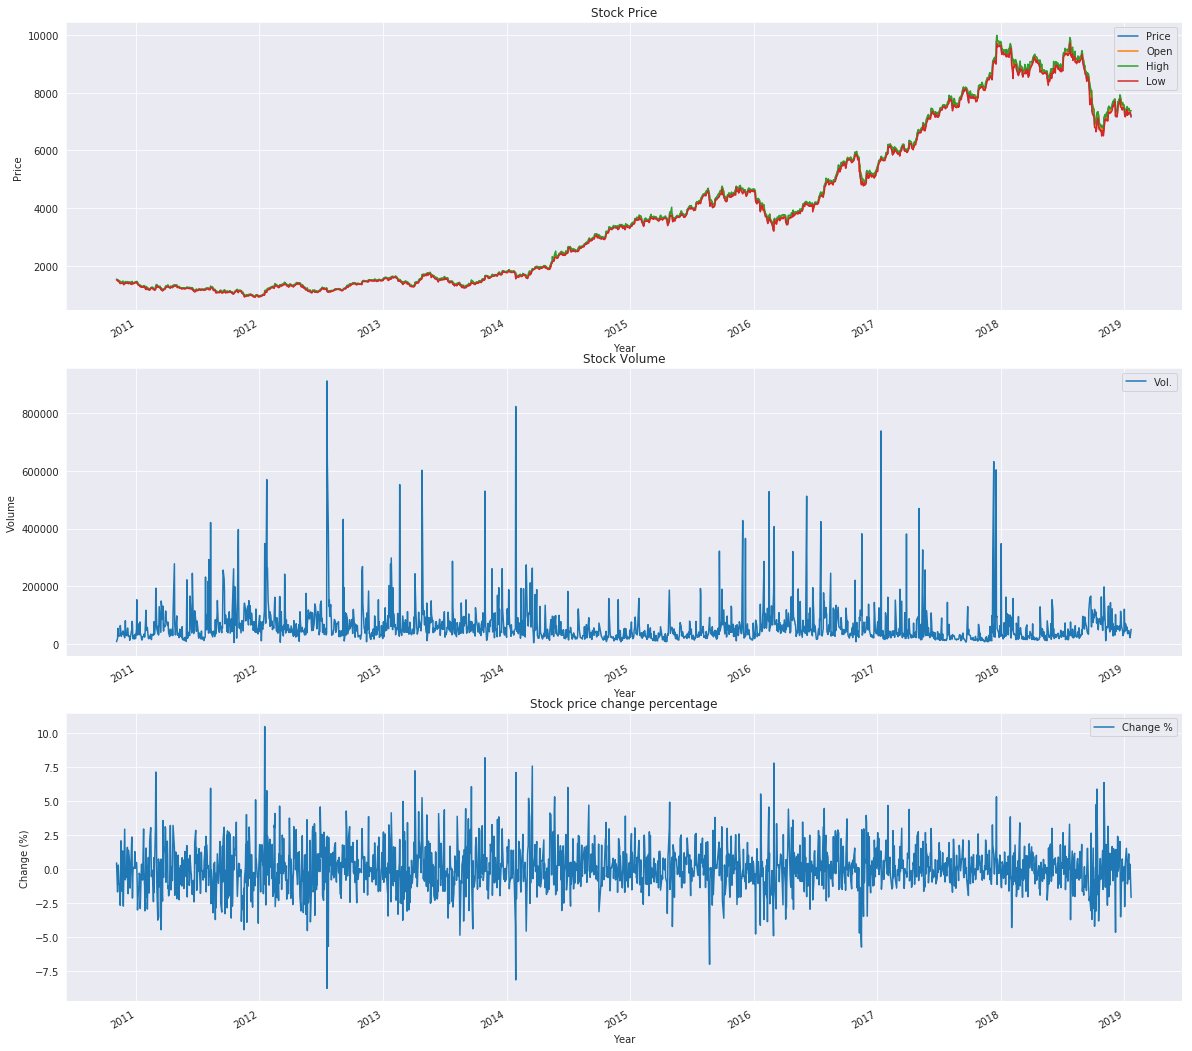

In [4]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
mrti_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
mrti_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
mrti_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.show()

In [5]:
mrti_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-05,1513.60,1525.0,1527.0,1509.10,8640.0,0.47
2010-11-08,1488.45,1500.0,1514.0,1485.00,20030.0,-1.66
2010-11-09,1470.65,1495.0,1506.0,1465.50,54770.0,-1.20
2010-11-10,1475.20,1471.0,1480.0,1459.30,27370.0,0.31
2010-11-11,1470.70,1487.0,1488.0,1466.25,28460.0,-0.31


In [6]:
mrti_data.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-15,7349.55,7438.7,7465.00,7321.00,36810.0,-0.72
2019-01-16,7305.25,7365.0,7384.75,7291.05,38530.0,-0.60
2019-01-17,7333.70,7325.0,7397.95,7310.25,26920.0,0.39
2019-01-18,7353.35,7365.0,7375.00,7324.70,22210.0,0.27
2019-01-21,7200.95,7384.0,7384.00,7160.45,51420.0,-2.07


In [7]:
mrti_data.shape

(2035, 6)

In [8]:
# split data
train_data = mrti_data.iloc[:1700,:]
test_data = mrti_data.iloc[1700:,:]

# normalize by splitting into window
window_size = 10
scaler = StandardScaler()

# normalize train data
for di in range(0, len(train_data), window_size):
    scaler.fit(train_data.iloc[di:di+window_size,:])
    train_data.iloc[di:di+window_size,:] = scaler.transform(train_data.iloc[di:di+window_size,:])

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [9]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-05,1.764507,1.605849,1.569817,-1.569462,0.895953
2010-11-08,0.958060,1.193320,1.054070,-0.831296,-0.763508
2010-11-09,0.796770,0.939456,0.636765,1.420144,-0.405126
2010-11-10,0.022581,0.114398,0.504083,-0.355603,0.771298
2010-11-11,0.538707,0.368262,0.652815,-0.284962,0.288263


In [10]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2017-09-14,1.423488,1.203152,1.159901,-0.960644,-1.641724
2017-09-15,0.935840,0.963913,1.178207,-0.964560,-0.622637
2017-09-18,1.417931,1.347639,1.737441,-1.726810,0.135464
2017-09-19,1.645778,1.448686,1.739577,-1.974803,-0.983046
2017-09-20,1.348743,1.174506,1.526012,-2.295888,-1.281315


In [11]:
y_train.head()

Date
2010-11-05    1.712281
2010-11-08    0.981518
2010-11-09    0.464318
2010-11-10    0.596524
2010-11-11    0.465771
Name: Price, dtype: float64

In [12]:
y_test.head()

Date
2017-09-14    0.914837
2017-09-15    1.024505
2017-09-18    1.453148
2017-09-19    1.413357
2017-09-20    1.243517
Name: Price, dtype: float64

In [13]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=20, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(40, return_sequences=False))
model.add(Dropout(0.3))

# add Dense layer with ReLU activation
model.add(Dense(20,activation='relu'))        

# add Dense layer with Linear activation
model.add(Dense(1,activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.04841160774230957


In [14]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=100, validation_split=0.05, batch_size=10)

Train on 1615 samples, validate on 85 samples
Epoch 1/100
1615/1615 [==============================] - 8s 5ms/step - loss: 0.5436 - mean_squared_error: 0.5436 - val_loss: 0.1520 - val_mean_squared_error: 0.1520
Epoch 2/100
1615/1615 [==============================] - 3s 2ms/step - loss: 0.1466 - mean_squared_error: 0.1466 - val_loss: 0.1245 - val_mean_squared_error: 0.1245
Epoch 3/100
1615/1615 [==============================] - 3s 2ms/step - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 4/100
1615/1615 [==============================] - 3s 2ms/step - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1038 - val_mean_squared_error: 0.1038
Epoch 5/100
1615/1615 [==============================] - 3s 2ms/step - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1020 - val_mean_squared_error: 0.1020
Epoch 6/100
1615/1615 [==============================] - 3s 2ms/step - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.10

1615/1615 [==============================] - 2s 2ms/step - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.0816 - val_mean_squared_error: 0.0816
Epoch 51/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.0797 - val_mean_squared_error: 0.0797
Epoch 52/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.1070 - mean_squared_error: 0.1070 - val_loss: 0.0790 - val_mean_squared_error: 0.0790
Epoch 53/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - val_loss: 0.0780 - val_mean_squared_error: 0.0780
Epoch 54/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.1030 - mean_squared_error: 0.1030 - val_loss: 0.0781 - val_mean_squared_error: 0.0781
Epoch 55/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.1039 - mean_squared_error: 0.1039 - val_loss: 0.0806 - val_mean_squared_error: 0.0806
Epoch 56/100
1615

1615/1615 [==============================] - 3s 2ms/step - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 100/100
1615/1615 [==============================] - 2s 2ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.0769 - val_mean_squared_error: 0.0769


In [15]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [16]:
preds

Date
2017-09-14    8005.387152
2017-09-15    8063.291207
2017-09-18    8147.769438
2017-09-19    8099.847833
2017-09-20    8063.234054
2017-09-21    8082.279534
2017-09-22    8004.297018
2017-09-25    7876.841315
2017-09-26    7839.384606
2017-09-27    7725.058228
2017-09-28    7897.198645
2017-09-29    7998.170700
2017-10-03    7849.811234
2017-10-04    7812.590113
2017-10-05    7822.299302
2017-10-06    7924.437391
2017-10-09    7869.712054
2017-10-10    7890.028571
2017-10-11    7770.809846
2017-10-12    7930.604471
2017-10-13    7840.895708
2017-10-16    7828.539396
2017-10-17    7846.048994
2017-10-18    7747.966262
2017-10-19    7721.982998
2017-10-23    7838.458074
2017-10-24    7913.333147
2017-10-25    7846.308672
2017-10-26    8123.773076
2017-10-27    8139.299513
                 ...     
2018-12-10    7612.217866
2018-12-11    7595.134744
2018-12-12    7689.911791
2018-12-13    7777.273672
2018-12-14    7669.819033
2018-12-17    7776.942709
2018-12-18    7753.659143
2018-12

In [17]:
actual

Date
2017-09-14    8071.25
2017-09-15    8088.20
2017-09-18    8154.45
2017-09-19    8148.30
2017-09-20    8122.05
2017-09-21    8132.65
2017-09-22    8074.55
2017-09-25    7952.80
2017-09-26    7885.55
2017-09-27    7733.90
2017-09-28    7897.15
2017-09-29    7973.15
2017-10-03    7888.50
2017-10-04    7842.80
2017-10-05    7838.40
2017-10-06    7909.85
2017-10-09    7892.75
2017-10-10    7897.75
2017-10-11    7820.05
2017-10-12    7904.40
2017-10-13    7872.20
2017-10-16    7847.50
2017-10-17    7849.55
2017-10-18    7789.60
2017-10-19    7736.35
2017-10-23    7819.40
2017-10-24    7875.35
2017-10-25    7871.80
2017-10-26    8076.50
2017-10-27    8114.80
               ...   
2018-12-10    7350.10
2018-12-11    7309.85
2018-12-12    7487.05
2018-12-13    7663.75
2018-12-14    7654.10
2018-12-17    7708.55
2018-12-18    7757.70
2018-12-19    7916.15
2018-12-20    7808.95
2018-12-21    7536.75
2018-12-24    7513.70
2018-12-26    7570.75
2018-12-27    7505.30
2018-12-28    7510.70
2018-

In [18]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

684.0232138735471


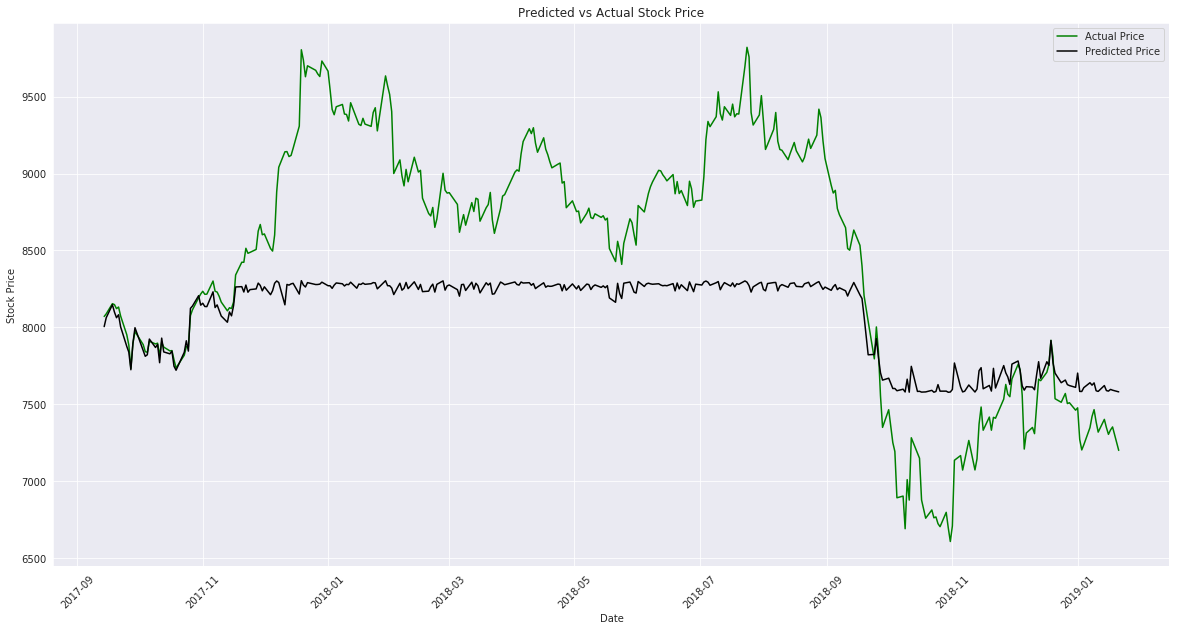

In [19]:
# comapre original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.show()